In [608]:

import pandas.io.sql as sqlio
import psycopg2
import plotly.graph_objects as go
import pandas as pd
import datetime
import calmap
from plotly.subplots import make_subplots
from pathlib import Path
import json
from numpy import quantile
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt, mpld3
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from datetime import timedelta
import requests
import calplot
#https://pythonhosted.org/calmap/

#https://medium.com/analytics-vidhya/calendar-heatmaps-a-perfect-way-to-display-your-time-series-quantitative-data-ad36bf81a3ed

In [609]:
def get_properties():
    props = {}
    separator = "="
            
    with open('./database.properties') as file:
        for line in file: 
            if separator in line:
                name, value = line.split(separator, 1)
                props[name.strip()] = value.strip()
    return props

In [333]:
class Database:
    def __init__(self):
        db_prop = get_properties()
        self.username = db_prop.get('username')
        self.password = db_prop.get('password')
        self.host = db_prop.get('host')
        self.port = db_prop.get('port')
        #self.database = db_prop.get('database')
        
    def connect(self, database):
        connection = psycopg2.connect(user=self.username,
                                      password=self.password,
                                      host=self.host,
                                      port=self.port,
                                      database=database)
        return connection, connection.cursor()
    
    def execute_query(self, query, database="habit"):
        result = None
        conn, cursor = None, None
        try:
            conn, cursor = self.connect(database)
            result = sqlio.read_sql_query(query, conn)
        except(Exception, psycopg2.Error) as error:
            print("Error while executing sql", error)
        finally:
            if conn:
                cursor.close()
                conn.close()
            return result
    
    def read_habits(self):
        query = 'SELECT "name", "date" FROM public.task order by date desc'
        return self.execute_query(query)
    def read_meditation(self):
        query = 'select * from meditation inner join task on meditation.task_fk = task.id order by date desc'
        return self.execute_query(query)    
    def read_fit(self):
        query = 'select * from exercise inner join task on exercise.task_fk = task.id order by date desc'
        return self.execute_query(query)
    def read_old_fit(self):
        query = 'select fit_activity.calories, fit_activity.heart_rate, fit_activity.duration, fit_activity.distance, activity.note,\
            activity.date from fit_activity inner join activity on activity_fk =activity.id '
        return self.execute_query(query, "Habits")
          
#select fit_activity.calories, fit_activity.heart_rate, fit_activity.duration, fit_activity.distance, activity.note, activity.date, activity.name
#from fit_activity
#FULL OUTER JOIN activity on activity_fk =activity.id

In [334]:
start_date_19 = datetime.date(2019 ,1,1)
start_date_20 = datetime.date(2020,1,1)
start_date_21 = datetime.date(2021,1,1)
start_date_22 = datetime.date(2022,1,1)
start_date_23 = datetime.date(2023,1,1)

In [357]:

db = Database()
habits = db.read_habits()
meditation = db.read_meditation()
fit_20 =db.read_old_fit()
fit_20 = fit_20[["date", "note", "calories", "distance","duration"]]
fit_20 = fit_20.rename(columns={"note": "name"})
fit_21= db.read_fit()


#### Old Fitbit

In [347]:

fit_20 = fit_20.sort_values(by=["date"])
fit_20.duration = fit_20.duration.astype(str)
fit_20.duration = pd.to_timedelta(fit_20.duration).astype('timedelta64[m]')
fit_20["distance"] = fit_20["distance"]/1609
fit_19 = fit_20[(fit_20.date>start_date_19) &  (fit_20.date<start_date_20)].copy()
fit_20 = fit_20[(fit_20.date>start_date_20)].copy()



fit_21 = fit_21[["date", "name","average_heart_rate", "calories", "steps", "distance", "duration", "timestamp"]]
fit_21.date = pd.to_datetime(fit_21.date).dt.date
fit_21 = fit_21[fit_21.date>start_date_21].copy()
fit_21.duration = fit_21.duration/60000
fit_21 = fit_21.drop_duplicates()
fit_21 = fit_21[np.invert([(fit_21["name"]=="Run") & (fit_21["duration"]>90)])[0]]
fit_21 = fit_21.sort_values(by=["date"])


#### Meditation Clean

In [348]:
meditations = {}
meditation = meditation[["date", "duration", "type"]]
meditation.date = pd.to_datetime(meditation.date).dt.date
meditation["duration"] = pd.to_timedelta(meditation.duration, unit="s").astype('timedelta64[m]')

meditations["20"] = meditation[(meditation.date > start_date_20) &  (meditation.date < start_date_21)].drop_duplicates()
meditations["21"] = meditation[(meditation.date > start_date_21) &  (meditation.date < start_date_22)].drop_duplicates()
meditations["22"] = meditation[(meditation.date > start_date_22) &  (meditation.date < start_date_23)].drop_duplicates()

#### Habit Clean

In [349]:
#habits["frequency"] = 1
#habits.date = pd.to_datetime(habits.date, utc=True).dt.tz_convert('US/Eastern')#.dt.date
#habits.date = habits.date - timedelta(days=1)
#habits.date = habits.date.dt.date
##habits = habits[(habits.date >start_date_22) & (habits.date < start_date_23)]
#habits = habits.drop_duplicates()

In [358]:
habits["frequency"] = 1
habits.date = pd.to_datetime(habits.date, utc=True).dt.tz_convert('US/Eastern')#.dt.date
#habits.date = habits.date - timedelta(days=1)
habits.date = habits.date.dt.date
#habits = habits[(habits.date >start_date_22) & (habits.date < start_date_23)]
habits = habits.drop_duplicates()

In [359]:
habits

name        date  frequency
0          Walk Dog  2022-12-11          1
1     Clean Patrick  2022-12-11          1
2               Cat  2022-12-11          1
3             Class  2022-12-11          1
4               Cat  2022-12-10          1
...             ...         ...        ...
4355       Meditate  2018-11-07          1
4356       Meditate  2018-11-05          1
4357            Run  2016-04-05          1
4358            Run  2016-04-04          1
4359            Run  2016-01-04          1

[4360 rows x 3 columns]

In [360]:
sdate = datetime.date(2018,6,1) 
edate = datetime.date(2022,12,31) 
date_range = pd.date_range(sdate,edate-datetime.timedelta(days=1),freq='d')

df = pd.DataFrame()
df["date"] = date_range
df["date"] = pd.to_datetime(date_range).date

key_habits = ["Meditate", "Run", "Yoga",  "Weights",  "Programming", "Class", "Notes",  "Andrew", "Read", "Study", "Walk Dog", "Garbage", "Plan Week", "Dishes", "Clean House"]

for key in key_habits:
    habit = habits[habits.name.str.contains(key)]
    df[key] = 0
    for date in habit.date:
        try:
            ind = df.index[df["date"] == date]
            df.at[ind.values[0], key] = 1
        except:
            print(f"Key: {key} ind {ind}")
df = df.rename(columns = {"Andrew": "Group Study"})
basket = df.copy()
df['Day'] = pd.to_datetime(df['date']).dt.day_name()
df['Month'] = pd.to_datetime(df['date']).dt.month
df['year-month'] = pd.to_datetime(df['date']).dt.strftime("%Y-%m")
month_df = df.groupby("year-month").sum()
month_df = month_df.reset_index()
month_df["year-month"] = pd.to_datetime(month_df["year-month"])
month_df["Exercise"] = month_df["Weights"] + month_df["Yoga"] + month_df["Run"]
month_df["Education"] = month_df["Programming"] + month_df["Class"] + month_df["Notes"]+ month_df["Study"]+ month_df["Read"] + month_df["Study"]


Key: Run ind Int64Index([], dtype='int64')
Key: Run ind Int64Index([], dtype='int64')
Key: Run ind Int64Index([], dtype='int64')


In [361]:
cats = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_current = df[df.date>start_date_22]
cat_type = CategoricalDtype(categories=cats, ordered=True)
day_df = df_current.groupby(by=["Day"]).sum()
day_df = day_df.reset_index()
day_df["Day"] = day_df["Day"].astype(cat_type)
day_df = day_df.sort_values(by=["Day"])
day_df

Day  Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
3     Sunday        16    2    19        0            1     30      0   
1     Monday        22   15     1        0            3     27      0   
5    Tuesday        21   20     3        0            2     36      0   
6  Wednesday        11    2    22        0            1     34      0   
4   Thursday        10    6     4        6            1     37      0   
0     Friday        10    4     3        1            0     29      0   
2   Saturday        11    2    27        0            0     28      0   

   Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
3            0     0      1        28        2          0       2   
1           12     0      1        35       16         28      11   
5           24     2      0        38       16         10       7   
6           19     1      0        31        0          1       3   
4           10     0      0        36        8          0       6   
0            0     1      1        29       10          1       2   
2            0     0      0        19        0          0       3   

   Clean House  Month  
3            3    335  
1            5    336  
5            5    339  
6            4    340  
4            1    342  
0            2    344  
2            2    333

In [355]:


layout=go.Layout(
        title=go.layout.Title(text="Habits"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
        

fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(x= month_df["year-month"], y = month_df["Meditate"], name = "Meditate"))
fig.add_trace(go.Scatter(x= month_df["year-month"], y = month_df["Exercise"], name = "Exercise"))
fig.add_trace(go.Scatter(x= month_df["year-month"], y = month_df["Education"], name = "Education"))


fig.update_xaxes(title="Date", dtick="M3")


shapes = [
        dict(
                type='line',
                yref='paper', y0=0, y1=1,
                xref='x',x0="2020-01-10",x1="2020-01-10",
                line_dash="dash",
                opacity=0.6
        ),
        
        dict(
                type='line',
                yref='paper', y0=0, y1=1,
                xref='x',x0="2021-08-29",x1="2021-08-29",
                line_dash="dash",
                opacity=0.6
        ),

        
]

fig.update_layout(shapes=shapes)


fig.add_annotation(x="2019-11-01", y=40,
            text="Covid Starts",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=16,
            )      
)

fig.add_annotation(x="2021-06-12", y=40,
            text="Masters Starts",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=16,
            )      
)
fig.write_html(f"./webpage_2022/ThreeCategories.html")
fig.show()

In [356]:

layout=go.Layout(
        title=go.layout.Title(text="Exercise"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
        
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(x= month_df["year-month"], y = month_df["Run"], name = "Run"))
fig.add_trace(go.Scatter(x= month_df["year-month"], y = month_df["Yoga"], name = "Yoga"))
fig.add_trace(go.Scatter(x= month_df["year-month"], y = month_df["Weights"], name = "Weights"))

fig.update_xaxes(title="Date", dtick="M3")

shapes = [
        dict(
                type='line',
                yref='paper', y0=0, y1=1,
                xref='x',x0="2020-01-10",x1="2020-01-10",
                line_dash="dash",
                opacity=0.6
        ),
        dict(
                type='line',
                yref='paper', y0=0, y1=1,
                xref='x',x0="2021-06-01",x1="2021-06-01",
                line_dash="dash",
                opacity=0.6
        ),

        dict(
                type='line',
                yref='paper', y0=0, y1=1,
                xref='x',x0="2020-11-01",x1="2020-11-01",
                line_dash="dash",
                opacity=0.6
        )
]


fig.update_layout(shapes=shapes)


fig.add_annotation(x="2019-11-01", y=18,
            text="Covid <br> Starts",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=10,
            )
)

fig.add_annotation(x="2021-03-08", y=18,
            text="Yoga Studio <br> Reopens",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=10,
            )
)
fig.add_annotation(x="2020-08-15", y=18,
            text="Shin <br> Splints",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=10,
            )
)
fig.write_html(f"./webpage_2022/ExerciseAllTime.html")

fig.show()

In [303]:
education_df = month_df[month_df["year-month"] > "2019-12-01"]


In [304]:

layout=go.Layout(
        title=go.layout.Title(text="Education"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
        
fig = go.Figure(layout=layout)

fig.add_shape(type="rect",
    xref="x", yref="y",
    x0="2020-01-01", y0=0,
    x1="2021-08-29", y1=26,
    line=dict(
        color="Blue",
        width=3,
    ),
    fillcolor="Blue",
    opacity=.1
)
fig.add_shape(type="rect",
    xref="x", yref="y",
    x0="2021-08-29", y0=0,
    x1="2022-12-29", y1=26,
    line=dict(
        color="Gold",
        width=3,
    ),
    fillcolor="Gold",
    opacity=.1
)




fig.add_trace(go.Scatter(x= education_df["year-month"], y = education_df["Class"], name = "Class"))
fig.add_trace(go.Scatter(x= education_df["year-month"], y = education_df["Notes"], name = "Notes"))
fig.add_trace(go.Scatter(x= education_df["year-month"], y = education_df["Group Study"], name = "Group Study"))
fig.add_trace(go.Scatter(x= education_df["year-month"], y = education_df["Study"], name = "Study"))
fig.add_trace(go.Scatter(x= education_df["year-month"], y = education_df["Read"], name = "Read"))
fig.add_trace(go.Scatter(x= education_df["year-month"], y = education_df["Programming"], name = "Programming"))

fig.update_xaxes(title="Date", dtick="M3")


fig.add_annotation(x="2020-10-01", y=22,
            text="Self Teaching",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=14,
            )
)

fig.add_annotation(x="2022-04-01", y=22,
            text="UMich Masters",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=14,
            )
)




fig.write_html(f"./webpage_2022/EductationAllTime.html")

fig.show()

In [305]:
month_df.head(3)

year-month  Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
0 2018-06-01         0    0     0        0            0      0      0   
1 2018-07-01         0    0     0        0            0      0      0   
2 2018-08-01         0    0     0        0            0      0      0   

   Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
0            0     0      0         0        0          0       0   
1            0     0      0         0        0          0       0   
2            0     0      0         0        0          0       0   

   Clean House  Month  Exercise  Education  
0            0    180         0          0  
1            0    217         0          0  
2            0    248         0          0

In [306]:
#basket = basket.drop("date",axis=1)
basket["Exercise"] = basket["Weights"] + basket["Yoga"] + basket["Run"]
basket["Education"] = basket["Programming"] + basket["Class"] + basket["Notes"]+ basket["Study"]+ basket["Read"] + basket["Study"]

In [307]:
corr = basket.corr()

In [308]:
frequent_itemsets = apriori(basket, min_support=0.07, use_colnames=True)

c:\Users\zeusg\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



ValueError: The allowed values for a DataFrame are True, False, 0, 1. Found value 2018-06-01

In [ ]:
frequent_itemsets.sort_values(by=["support"])

support                   itemsets
11  0.070490    (Group Study, Meditate)
17  0.071087        (Garbage, Walk Dog)
6   0.072879                     (Read)
10  0.074074           (Yoga, Meditate)
18  0.082437  (Run, Walk Dog, Meditate)
14  0.086022           (Walk Dog, Yoga)
8   0.087814                  (Garbage)
16  0.093190    (Group Study, Walk Dog)
3   0.093190              (Programming)
13  0.102748            (Run, Walk Dog)
5   0.109916              (Group Study)
9   0.111111            (Run, Meditate)
15  0.139785          (Class, Walk Dog)
1   0.146953                      (Run)
2   0.153524                     (Yoga)
4   0.178017                    (Class)
12  0.190562       (Walk Dog, Meditate)
0   0.326762                 (Meditate)
7   0.384110                 (Walk Dog)

In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

NameError: name 'frequent_itemsets' is not defined

In [ ]:
rules.lift.max()

NameError: name 'rules' is not defined

In [ ]:
rules[ (rules['lift'] >= 1.6) &
       (rules['confidence'] >= 0.8) ].sort_values(by=["confidence"])

NameError: name 'rules' is not defined

In [ ]:
basket

date  Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
0     2018-06-01         0    0     0        0            0      0      0   
1     2018-06-02         0    0     0        0            0      0      0   
2     2018-06-03         0    0     0        0            0      0      0   
3     2018-06-04         0    0     0        0            0      0      0   
4     2018-06-05         0    0     0        0            0      0      0   
...          ...       ...  ...   ...      ...          ...    ...    ...   
1669  2022-12-26         0    0     0        0            0      0      0   
1670  2022-12-27         0    0     0        0            0      0      0   
1671  2022-12-28         0    0     0        0            0      0      0   
1672  2022-12-29         0    0     0        0            0      0      0   
1673  2022-12-30         0    0     0        0            0      0      0   

      Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
0               0     0      0         0        0          0       0   
1               0     0      0         0        0          0       0   
2               0     0      0         0        0          0       0   
3               0     0      0         0        0          0       0   
4               0     0      0         0        0          0       0   
...           ...   ...    ...       ...      ...        ...     ...   
1669            0     0      0         0        0          0       0   
1670            0     0      0         0        0          0       0   
1671            0     0      0         0        0          0       0   
1672            0     0      0         0        0          0       0   
1673            0     0      0         0        0          0       0   

      Clean House  Exercise  Education  
0               0         0          0  
1               0         0          0  
2               0         0          0  
3               0         0          0  
4               0         0          0  
...           ...       ...        ...  
1669            0         0          0  
1670            0         0          0  
1671            0         0          0  
1672            0         0          0  
1673            0         0          0  

[1674 rows x 18 columns]

In [ ]:
corrMatrix = basket[[
'Walk Dog',
 'Clean House',
 'Dishes',
 'Garbage',
 'Plan Week',
 'Meditate',
 'Education',
 'Exercise']].corr()
corrMatrix


Walk Dog  Clean House    Dishes   Garbage  Plan Week  Meditate  \
Walk Dog     1.000000     0.174102  0.214709  0.271376   0.236490  0.285142   
Clean House  0.174102     1.000000  0.456441  0.141824   0.323880  0.153710   
Dishes       0.214709     0.456441  1.000000  0.225495   0.236742  0.127569   
Garbage      0.271376     0.141824  0.225495  1.000000   0.319074  0.224852   
Plan Week    0.236490     0.323880  0.236742  0.319074   1.000000  0.217917   
Meditate     0.285142     0.153710  0.127569  0.224852   0.217917  1.000000   
Education    0.476635     0.108027  0.175796  0.287789   0.213631  0.329702   
Exercise     0.301600     0.076750  0.052388  0.188605   0.087295  0.383248   

             Education  Exercise  
Walk Dog      0.476635  0.301600  
Clean House   0.108027  0.076750  
Dishes        0.175796  0.052388  
Garbage       0.287789  0.188605  
Plan Week     0.213631  0.087295  
Meditate      0.329702  0.383248  
Education     1.000000  0.292653  
Exercise      0.292653  1.000000

In [ ]:
corr

Meditate       Run      Yoga   Weights  Programming     Class  \
Meditate     1.000000  0.379927  0.141400  0.143340     0.289275  0.032046   
Run          0.379927  1.000000  0.038533  0.000432     0.151340  0.058256   
Yoga         0.141400  0.038533  1.000000  0.011245     0.017387  0.278329   
Weights      0.143340  0.000432  0.011245  1.000000     0.122083  0.014796   
Programming  0.289275  0.151340  0.017387  0.122083     1.000000 -0.138441   
Class        0.032046  0.058256  0.278329  0.014796    -0.138441  1.000000   
Notes        0.132686  0.075757 -0.026609 -0.012969     0.049514 -0.047137   
Group Study  0.235665  0.215553  0.120535  0.000489     0.045023  0.270829   
Read         0.191752  0.078355  0.078221  0.018832     0.210531 -0.052376   
Study        0.157864  0.122870 -0.012380  0.011018     0.017121 -0.052361   
Walk Dog     0.285142  0.268869  0.154281  0.074381     0.173556  0.383795   
Garbage      0.224852  0.222942  0.061079 -0.006216     0.053011  0.225297   
Plan Week    0.217917  0.200282 -0.057432 -0.030520     0.042027  0.193715   
Dishes       0.127569  0.050674  0.016037  0.032554     0.051138  0.076012   
Clean House  0.153710  0.072911  0.040573  0.002552     0.020358  0.069747   
Exercise     0.383248  0.692897  0.707107  0.245106     0.141648  0.231261   
Education    0.329702  0.209158  0.199054  0.076363     0.480404  0.488799   

                Notes  Group Study      Read     Study  Walk Dog   Garbage  \
Meditate     0.132686     0.235665  0.191752  0.157864  0.285142  0.224852   
Run          0.075757     0.215553  0.078355  0.122870  0.268869  0.222942   
Yoga        -0.026609     0.120535  0.078221 -0.012380  0.154281  0.061079   
Weights     -0.012969     0.000489  0.018832  0.011018  0.074381 -0.006216   
Programming  0.049514     0.045023  0.210531  0.017121  0.173556  0.053011   
Class       -0.047137     0.270829 -0.052376 -0.052361  0.383795  0.225297   
Notes        1.000000     0.135845  0.017444  0.140206  0.091509  0.158040   
Group Study  0.135845     1.000000  0.055767  0.170115  0.335034  0.397068   
Read         0.017444     0.055767  1.000000  0.031372  0.213276  0.042928   
Study        0.140206     0.170115  0.031372  1.000000  0.125742  0.172582   
Walk Dog     0.091509     0.335034  0.213276  0.125742  1.000000  0.271376   
Garbage      0.158040     0.397068  0.042928  0.172582  0.271376  1.000000   
Plan Week    0.055105     0.288805  0.004492  0.136126  0.236490  0.319074   
Dishes       0.134354     0.204130  0.086004  0.101442  0.214709  0.225495   
Clean House  0.113696     0.115183 -0.001038  0.079656  0.174102  0.141824   
Exercise     0.029366     0.225625  0.109794  0.076120  0.301600  0.188605   
Education    0.228540     0.312319  0.495921  0.496186  0.476635  0.287789   

             Plan Week    Dishes  Clean House  Exercise  Education  
Meditate      0.217917  0.127569     0.153710  0.383248   0.329702  
Run           0.200282  0.050674     0.072911  0.692897   0.209158  
Yoga         -0.057432  0.016037     0.040573  0.707107   0.199054  
Weights      -0.030520  0.032554     0.002552  0.245106   0.076363  
Programming   0.042027  0.051138     0.020358  0.141648   0.480404  
Class         0.193715  0.076012     0.069747  0.231261   0.488799  
Notes         0.055105  0.134354     0.113696  0.029366   0.228540  
Group Study   0.288805  0.204130     0.115183  0.225625   0.312319  
Read          0.004492  0.086004    -0.001038  0.109794   0.495921  
Study         0.136126  0.101442     0.079656  0.076120   0.496186  
Walk Dog      0.236490  0.214709     0.174102  0.301600   0.476635  
Garbage       0.319074  0.225495     0.141824  0.188605   0.287789  
Plan Week     1.000000  0.236742     0.323880  0.087295   0.213631  
Dishes        0.236742  1.000000     0.456441  0.052388   0.175796  
Clean House   0.323880  0.456441     1.000000  0.076750   0.108027  
Exercise      0.087295  0.052388     0.076750  1.000000   0.292653  
Education     0.213631  0.1757

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x=list(corrMatrix.columns)[::-1],
        y=corrMatrix.columns,
        z=corrMatrix.values.tolist()[::-1],
    ))
fig.update_layout(
    title="Correlation Of Habits",
)
fig.write_html("./webpage/heatmap.html")
fig.show()

In [ ]:
df

date  Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
0     2018-06-01         0    0     0        0            0      0      0   
1     2018-06-02         0    0     0        0            0      0      0   
2     2018-06-03         0    0     0        0            0      0      0   
3     2018-06-04         0    0     0        0            0      0      0   
4     2018-06-05         0    0     0        0            0      0      0   
...          ...       ...  ...   ...      ...          ...    ...    ...   
1669  2022-12-26         0    0     0        0            0      0      0   
1670  2022-12-27         0    0     0        0            0      0      0   
1671  2022-12-28         0    0     0        0            0      0      0   
1672  2022-12-29         0    0     0        0            0      0      0   
1673  2022-12-30         0    0     0        0            0      0      0   

      Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
0               0     0      0         0        0          0       0   
1               0     0      0         0        0          0       0   
2               0     0      0         0        0          0       0   
3               0     0      0         0        0          0       0   
4               0     0      0         0        0          0       0   
...           ...   ...    ...       ...      ...        ...     ...   
1669            0     0      0         0        0          0       0   
1670            0     0      0         0        0          0       0   
1671            0     0      0         0        0          0       0   
1672            0     0      0         0        0          0       0   
1673            0     0      0         0        0          0       0   

      Clean House        Day  Month year-month  
0               0     Friday      6    2018-06  
1               0   Saturday      6    2018-06  
2               0     Sunday      6    2018-06  
3               0     Monday      6    2018-06  
4               0    Tuesday      6    2018-06  
...           ...        ...    ...        ...  
1669            0     Monday     12    2022-12  
1670            0    Tuesday     12    2022-12  
1671            0  Wednesday     12    2022-12  
1672            0   Thursday     12    2022-12  
1673            0     Friday     12    2022-12  

[1674 rows x 19 columns]

In [309]:
years = [21, 22]
totals = {}
#meditation[(meditation.date > start_date_20) &  (meditation.date < start_date_21)].drop_duplicates()

totals[21] = df[(df.date> start_date_21) &  (df.date < start_date_22)].sum()
totals[22] = df[(df.date> start_date_22) &  (df.date < start_date_23)].sum()



C:\Users\zeusg\AppData\Local\Temp/ipykernel_44884/4108145211.py:5: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\zeusg\AppData\Local\Temp/ipykernel_44884/4108145211.py:6: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [310]:
df[(df.date> start_date_22) &  (meditation.date < start_date_22)]

C:\Users\zeusg\AppData\Local\Temp/ipykernel_44884/1977327439.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



date  Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
1311  2022-01-02         1    0     1        0            0      0      0   
1312  2022-01-03         1    0     1        0            1      0      0   
1313  2022-01-04         1    0     1        0            1      0      0   
1314  2022-01-05         0    0     0        1            0      1      0   
1315  2022-01-06         1    0     0        0            0      0      0   
...          ...       ...  ...   ...      ...          ...    ...    ...   
1669  2022-12-26         0    0     0        0            0      0      0   
1670  2022-12-27         0    0     0        0            0      0      0   
1671  2022-12-28         0    0     0        0            0      0      0   
1672  2022-12-29         0    0     0        0            0      0      0   
1673  2022-12-30         0    0     0        0            0      0      0   

      Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
1311            0     1      0         1        0          0       0   
1312            1     0      0         0        0          0       0   
1313            0     0      0         1        1          0       1   
1314            0     0      0         0        0          0       0   
1315            0     0      0         0        0          0       0   
...           ...   ...    ...       ...      ...        ...     ...   
1669            0     0      0         0        0          0       0   
1670            0     0      0         0        0          0       0   
1671            0     0      0         0        0          0       0   
1672            0     0      0         0        0          0       0   
1673            0     0      0         0        0          0       0   

      Clean House        Day  Month year-month  
1311            1     Sunday      1    2022-01  
1312            0     Monday      1    2022-01  
1313            0    Tuesday      1    2022-01  
1314            0  Wednesday      1    2022-01  
1315            0   Thursday      1    2022-01  
...           ...        ...    ...        ...  
1669            0     Monday     12    2022-12  
1670            0    Tuesday     12    2022-12  
1671            0  Wednesday     12    2022-12  
1672            0   Thursday     12    2022-12  
1673            0     Friday     12    2022-12  

[363 rows x 19 columns]

In [311]:

for year in years:
    program_total = totals[year]["Programming"]
    class_total = totals[year]["Class"]
    group_total = totals[year]["Group Study"]
    reading_total = totals[year]["Read"]
    misc_total = totals[year]["Study"] + totals[year] ["Notes"]

    other_total = misc_total + program_total+ reading_total

    weights_total = totals[year]["Weights"]
    yoga_total = totals[year]["Yoga"]
    run_total = totals[year]["Run"]
    meditation_daily = len(meditations[str(year)][meditations[str(year)]["type"].str.contains("Daily")])
    meditation_self = len(meditations[str(year)][meditations[str(year)]["type"].str.contains("Self")])
    meditation_total = totals[year]["Meditate"]
    meditation_other = meditation_total - (meditation_daily + meditation_self)

    exercise_total = weights_total + yoga_total + run_total
    learning_total = program_total + class_total + group_total + reading_total + misc_total
    all_total = exercise_total+ learning_total+ meditation_total
    
    fig =go.Figure(go.Sunburst(
        labels=[f"All: 20{year}", "Exercise", "Learning", "Meditation", "Timer", "Guided", "Other", "Misc", "Class", "Group Study",  "Weights", "Yoga", "Running"],
        parents=["", f"All: 20{year}", f"All: 20{year}", f"All: 20{year}", "Meditation", "Meditation", "Meditation",  "Learning", "Learning", "Learning", "Exercise", "Exercise", "Exercise"],
        values=[all_total, exercise_total, learning_total, meditation_total, meditation_self, meditation_daily, meditation_other, other_total, class_total, group_total, weights_total, yoga_total, run_total],
        textinfo= 'label+value',
        branchvalues="total",
    ))  
    #fig.update_layout(
    #    autosize=False,
    #    width=800,
    #    height=800,)
    fig.write_html(f"./webpage_2022/sunburst_{year}.html")
    fig.show()



In [312]:
meditation_daily = len(meditations["22"][meditations["22"]["type"].str.contains("Daily")])
meditation_self = len(meditations["22"][meditations["22"]["type"].str.contains("Self")])



In [313]:
program_19 = 102
reading_19 = 78
math_19 = 18
run_19 = 74
yoga_19 = 64
weights_19 =10
meditation_19_total=213
meditation_daily_19 = len(meditations["20"][meditations["20"]["type"].str.contains("Daily")])
meditation_self_19 = len(meditations["20"][meditations["20"]["type"].str.contains("Self")])
meditation_other_19 = meditation_19_total -meditation_daily_19-meditation_self_19

learning_total_19 = program_19+reading_19+math_19
exercise_total_19 = run_19+yoga_19+weights_19
all_19 = learning_total_19+exercise_total_19+meditation_19_total


In [315]:
fig =go.Figure(go.Sunburst(
    labels=["All: 2020", "Exercise", "Learning", "Meditation", "Timer", "Guided", "Other", "Programming", "Reading", "Math", "Weights", "Yoga", "Running" ],
    parents=["", "All: 2020", "All: 2020", "All: 2020", "Meditation", "Meditation", "Meditation", "Learning", "Learning",  "Learning", "Exercise", "Exercise", "Exercise", ],
    values=[all_19,  exercise_total_19, learning_total_19, meditation_19_total, meditation_self_19, meditation_daily_19, meditation_other_19, program_19, reading_19, math_19, weights_19, yoga_19, run_19],
    textinfo= 'label+value',
    branchvalues="total",
))
fig.write_html("./webpage_2022/sunburst_20.html")
fig.show()

In [316]:
#props = get_properties()
#directory = Path(props['fit_file_location'])
#fit_heart_rates = {}
##fit_calories = {}
#
#for _,exercise in fit_21.iterrows():
#    heart_rate_file_name = "heart_rate-" + str(exercise.date)+".json"
#    heart_rate_path = directory.joinpath('Physical Activity/'+heart_rate_file_name)
#    
#    #calories_file_name = "calories-" + str(exercise.date)+".json"
#    #calories_path = directory.joinpath('Physical Activity/'+calories_file_name)
#    
#    duration = pd.to_timedelta(exercise.duration, unit="m")
#    start = pd.to_datetime(str(exercise.date) + " " + str(exercise.timestamp))
#    end = start + duration
#    #Heart Rate
#    with open(heart_rate_path) as heart_rate_file:
#        heart_rate = json.load(heart_rate_file)
#        exercise_heart_rate = [heart_rate_data for heart_rate_data in heart_rate 
#                               if (pd.to_datetime(heart_rate_data["dateTime"]) > start) &
#                               (pd.to_datetime(heart_rate_data["dateTime"]) < end)]
#        try:
#            heart_rate_df = pd.DataFrame(exercise_heart_rate)
#            heart_rate_df["bpm"] =  heart_rate_df.value.apply(lambda x: x.get("bpm"))
#            fit_heart_rates[str(exercise.date) + " " + str(exercise["name"])] = heart_rate_df
#        except:
#            fit_21 = fit_21[(fit_21.date != exercise.date) & (fit_21.name != exercise.name)]
#            print("failed on " + str(exercise.date) + " " + str(exercise["name"]))
#            
#    #Calories
#    #with open(calories_path) as calories_file:
#    #    calories = json.load(calories_file)
#    #    exercise_calories = [calories_data for calories_data in calories 
#    #                           if (pd.to_datetime(calories_data["dateTime"]) > start) &
#    #                           (pd.to_datetime(calories_data["dateTime"]) < end)]
#    #    try:
#    #        calories_df = pd.DataFrame(exercise_calories)
#    #        fit_calories[str(exercise.date) + " " + str(exercise["name"])] = calories_df
#    #    except:
#    #        fit_21 = fit_21[(fit_21.date != exercise.date) & (fit_21.name != exercise.name)]
#    #        print("failed on " + str(exercise.date) + " " + str(exercise["name"]))
#    
#    
#

In [320]:
df

date  Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
0     2018-06-01         0    0     0        0            0      0      0   
1     2018-06-02         0    0     0        0            0      0      0   
2     2018-06-03         0    0     0        0            0      0      0   
3     2018-06-04         0    0     0        0            0      0      0   
4     2018-06-05         0    0     0        0            0      0      0   
...          ...       ...  ...   ...      ...          ...    ...    ...   
1669  2022-12-26         0    0     0        0            0      0      0   
1670  2022-12-27         0    0     0        0            0      0      0   
1671  2022-12-28         0    0     0        0            0      0      0   
1672  2022-12-29         0    0     0        0            0      0      0   
1673  2022-12-30         0    0     0        0            0      0      0   

      Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
0               0     0      0         0        0          0       0   
1               0     0      0         0        0          0       0   
2               0     0      0         0        0          0       0   
3               0     0      0         0        0          0       0   
4               0     0      0         0        0          0       0   
...           ...   ...    ...       ...      ...        ...     ...   
1669            0     0      0         0        0          0       0   
1670            0     0      0         0        0          0       0   
1671            0     0      0         0        0          0       0   
1672            0     0      0         0        0          0       0   
1673            0     0      0         0        0          0       0   

      Clean House        Day  Month year-month  
0               0     Friday      6    2018-06  
1               0   Saturday      6    2018-06  
2               0     Sunday      6    2018-06  
3               0     Monday      6    2018-06  
4               0    Tuesday      6    2018-06  
...           ...        ...    ...        ...  
1669            0     Monday     12    2022-12  
1670            0    Tuesday     12    2022-12  
1671            0  Wednesday     12    2022-12  
1672            0   Thursday     12    2022-12  
1673            0     Friday     12    2022-12  

[1674 rows x 19 columns]

In [317]:
cats = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_current = df[df.date>start_date_22]
cat_type = CategoricalDtype(categories=cats, ordered=True)
day_df = df_current.groupby(by=["Day"]).sum()
day_df = day_df.reset_index()
day_df["Day"] = day_df["Day"].astype(cat_type)
day_df = day_df.sort_values(by=["Day"])
day_df

Day  Meditate  Run  Yoga  Weights  Programming  Class  Notes  \
3     Sunday        21   20     3        0            2     36      0   
1     Monday        11    2    22        0            1     34      0   
5    Tuesday        10    6     4        6            1     37      0   
6  Wednesday        10    4     3        1            0     29      0   
4   Thursday        11    2    27        0            0     28      0   
0     Friday        16    2    19        0            1     30      0   
2   Saturday        21   15     1        0            2     27      0   

   Group Study  Read  Study  Walk Dog  Garbage  Plan Week  Dishes  \
3           24     2      0        38       16         10       7   
1           19     1      0        31        0          1       3   
5           10     0      0        36        8          0       6   
6            0     1      1        29       10          1       2   
4            0     0      0        19        0          0       3   
0            0     0      1        28        2          0       2   
2           11     0      1        34       15         27      11   

   Clean House  Month  
3            5    335  
1            4    336  
5            1    339  
6            2    340  
4            2    342  
0            3    344  
2            5    333

In [363]:
#https://community.plotly.com/t/combination-of-grouped-and-stacked-bar-chart/2154/2
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Meditate"],
        name="Meditate",
    ))


fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Run"] + day_df["Yoga"] + day_df["Weights"], 
        name="Exercise",

        
    ))
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Programming"] + day_df["Class"] + day_df["Notes"]+ day_df["Read"] + day_df["Study"] + day_df["Group Study"],
        name="Study",
        legendgroup = '1',        
))
fig.update_layout(
    title="Habit Daily Frequency",
    yaxis=dict(
        title_text="Frequency",
        ),
    xaxis=dict(
        title_text="Day Of The Week",
    ),
    
)
fig.update_layout(barmode='group')
fig.write_html("./webpage_2022/habitMetaFrequency.html")
fig.show()

In [364]:
fig = make_subplots(
    rows = 1, 
    cols=2,
    specs=[[{}, {}]],
    subplot_titles=("Exercise", "Education"))
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Yoga"],
        name="Yoga",
        legendgroup = '1',
    ),row=1,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Weights"],
        name="Weights",
        legendgroup = '1',
    ),row=1,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Run"],
        name="Run",
        legendgroup = '1',
    ),row=1,col=1)


fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Programming"] + day_df["Read"] + day_df["Notes"] + day_df["Study"],
        name="Misc",
        legendgroup = '2',
    ),row=1,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Class"],
        name="Class",
        legendgroup = '2',
    ),row=1,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Group Study"],
        name="Group Study",
        legendgroup = '2',
    ),row=1,col=2) 

fig.update_layout(
    title="Habit Daily Detailed Frequency",
)
fig['layout']['xaxis']['title']='Days Of The Week'
fig['layout']['xaxis2']['title']='Days Of The Week'
fig['layout']['yaxis']['title']='Frequency'
fig['layout']['yaxis2']['title']='Frequency'
fig.write_html("./webpage_2022/habitFrequency.html")

fig.show()

In [365]:
fig = make_subplots(
    rows = 2, 
    cols=2,
    specs=[[{"colspan": 2}, None],
           [{}, {}]],
    subplot_titles=("Meta Categoreis","Exercise", "Education"))
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Meditate"],
        name="Meditate",
        legendgroup = '1',
    ),row=1,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Yoga"] + day_df["Weights"] + day_df["Run"], 
        name="Exercise",
        legendgroup = '1',
    ),row=1,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Programming"] + day_df["Class"] + day_df["Notes"]+ day_df["Read"] + day_df["Study"] + day_df["Group Study"],
        name="Study",
        legendgroup = '1',
    ),row=1,col=1)

fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Yoga"],
        name="Yoga",
        legendgroup = '2',
    ),row=2,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Weights"],
        name="Weights",
        legendgroup = '2',
    ),row=2,col=1)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Run"],
        name="Run",
        legendgroup = '2',
    ),row=2,col=1)


fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Programming"],
        name="Programming",
        legendgroup = '3',
    ),row=2,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Class"],
        name="Class",
        legendgroup = '3',
    ),row=2,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Read"],
        name="Read",
        legendgroup = '3',
    ),row=2,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Group Study"],
        name="Group Study",
        legendgroup = '3',
    ),row=2,col=2)
fig.add_trace(
    go.Bar(
        x=day_df["Day"],
        y=day_df["Notes"] + day_df["Study"],
        name="Misc",
        legendgroup = '3',
    ),row=2,col=2)

fig.update_layout(
    title="Habit Daily Frequency",
    legend_tracegroupgap = 170,
    autosize=False,
    width=1200,
    height=800,
)
fig['layout']['xaxis']['title']='Days Of The Week'
fig['layout']['xaxis2']['title']='Days Of The Week'
fig['layout']['xaxis3']['title']='Days Of The Week'
fig['layout']['yaxis']['title']='Frequency'
fig['layout']['yaxis2']['title']='Frequency'
fig['layout']['yaxis3']['title']='Frequency'
fig.write_html("./webpage_2022/habitFrequency.html")

fig.show()

In [367]:
fig = go.Figure([go.Bar(
    x = df.date,
    y = df.Meditate,
)])

fig.show()

date  Meditate  Run  Yoga  Weights  Programming  Class  Group Study  \
0  2021-01-01         0    0     0        0            0      0            0   

   Read  Study  Walk Dog  Garbage  Plan Week  Dishes  Clean House  
0     0      0         0        0          0       0            0

In [366]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x = df.date,
    y = df.Run,
    name = "Run",
))
fig.add_trace(go.Bar(
    x = df.date,
    y = df.Yoga,
    name = "Yoga",
))
fig.add_trace(go.Bar(
    x = df.date,
    y = df.Weights,
    name = "Weights",
))

fig.show()

In [14]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x = df.date,
    y = df["Group Study"],
    name = "Group",
))
fig.show()

In [548]:
cal_df = df_current.copy()
cal_df["date"] = pd.to_datetime(cal_df["date"])
cal_df = cal_df.set_index("date")
cal_df["Education"] = cal_df["Class"]+cal_df["Notes"] + cal_df["Group Study"] + cal_df["Read"]
cal_df["Education"] = cal_df["Education"].clip(upper=1)

In [539]:
cal_df["Class"].max()

1

(<Figure size 720x122.4 with 1 Axes>,
 array([<AxesSubplot:ylabel='2022'>], dtype=object))

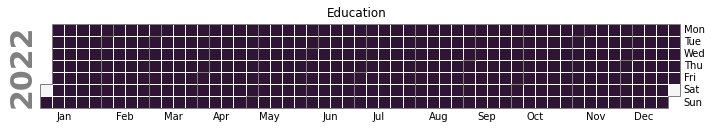

In [533]:
#for habit in cal_df.columns:
#    ax = calmap.calendarplot(cal_df[habit], monthticks=3, daylabels='MTWTFSS',
#                    dayticks=[0, 2, 4, 6],
#                    fillcolor='grey', linewidth=1,
#                    fig_kws=dict(figsize=(20, 40)))
#    ax[1][0].set_xlabel(habit, fontsize=20)



ValueError: 'fdsa' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

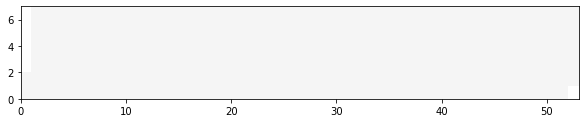

In [550]:
calplot.calplot(cal_df["Education"], cmap = 'fdsa', colorbar=False, suptitle="Education")

In [559]:
test = cal_df.iloc[30:50]["Education"]

In [571]:
cal_df["Class"].unique()

array([0, 1], dtype=int64)

In [573]:
cal_df["Yoga"].unique()

array([0, 1], dtype=int64)

(<Figure size 720x122.4 with 1 Axes>,
 array([<AxesSubplot:ylabel='2022'>], dtype=object))

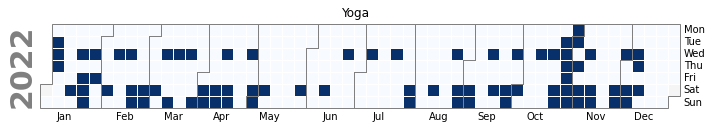

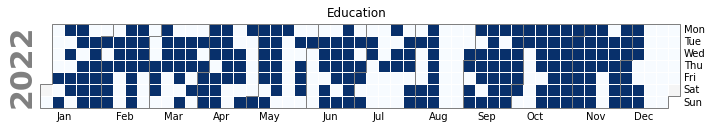

In [582]:
calplot.calplot(cal_df["Yoga"]+1, cmap = 'Blues', colorbar=False, suptitle="Yoga")
calplot.calplot(cal_df["Class"], cmap = 'Blues', colorbar=False, suptitle="Education")

In [ ]:
cal_df = df_current.copy()
cal_df["date"] = pd.to_datetime(cal_df["date"])
cal_df = cal_df.set_index("date")
cal_df["Education"] = cal_df["Class"]+cal_df["Notes"] + cal_df["Group Study"] + cal_df["Read"]
cal_df["Education"] = cal_df["Education"].clip(upper=1)

(<Figure size 1152x144 with 1 Axes>,
 array([<AxesSubplot:ylabel='2022'>], dtype=object))

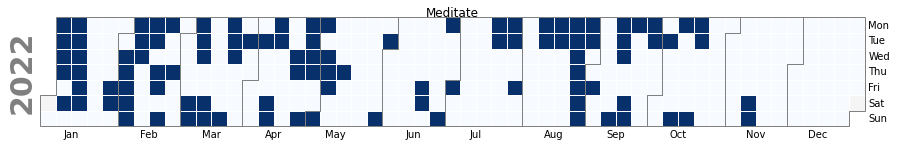

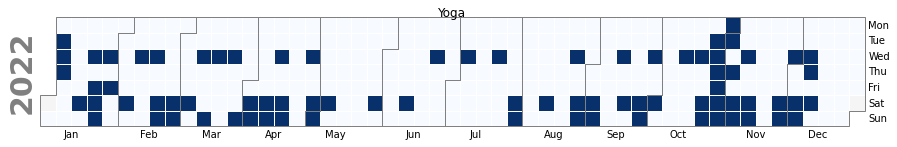

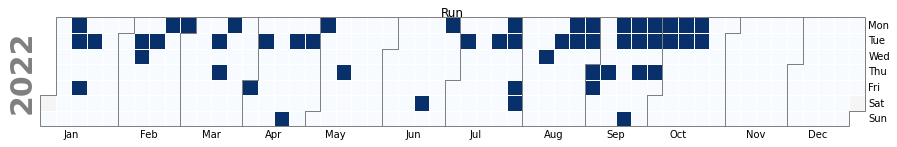

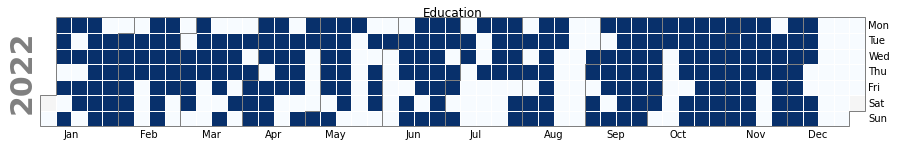

In [682]:
#pl1 = calplot.calplot(data = cal_df["Yoga"],how = 'sum', cmap = 'Reds', figsize = (16, 8), suptitle = "Total Sales by Month and Year")
calplot.calplot(cal_df["Meditate"]+1, cmap = 'Blues', colorbar=False, suptitle="Meditate", figsize = (16, 2))
calplot.calplot(cal_df["Yoga"]+1, cmap = 'Blues', colorbar=False, suptitle="Yoga", figsize = (16, 2))
calplot.calplot(cal_df["Run"]+1, cmap = 'Blues', colorbar=False, suptitle="Run", figsize = (16, 2))
calplot.calplot(cal_df["Education"], cmap = 'Blues', colorbar=False, suptitle="Education", figsize = (16, 2))

In [ ]:
cal_df = df_current.copy()
cal_df["date"] = pd.to_datetime(cal_df["date"])
cal_df = cal_df.set_index("date")
cal_df["Education"] = cal_df["Class"]+cal_df["Notes"] + cal_df["Group Study"] + cal_df["Read"]


Text(0.5, 300.0811320754717, 'Run')

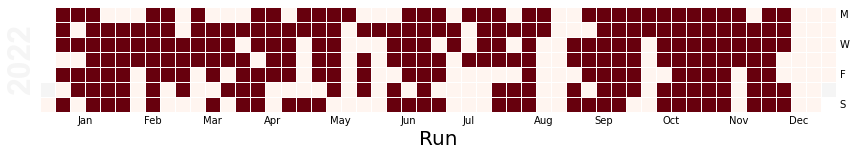

In [535]:
ax = calmap.calendarplot(cal_df["Education"], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    linewidth=1,
                    fig_kws=dict(figsize=(12, 10)))
ax[1][0].set_xlabel("Run", fontsize=20)

# Meditation

In [740]:
meditation.head(4)
medtation_no_theory = meditation[(meditation["type"].str.contains("Daily")) | (meditation["type"].str.contains("Self"))]
medtation_no_theory.duration = meditation.duration.astype(int)
medtation_no_theory = medtation_no_theory.sort_values(by=["date"])
medtation_no_theory = medtation_no_theory.drop_duplicates()
medtation_no_theory

C:\Users\zeusg\Envs\habit\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



date  duration              type
442  2021-01-04        20  Daily Meditation
439  2021-01-05        20  Daily Meditation
436  2021-01-06        10  Daily Meditation
433  2021-01-07        20  Daily Meditation
430  2021-01-08        20  Daily Meditation
..          ...       ...               ...
4    2021-10-25        20  Daily Meditation
3    2021-10-26        11        Self Timer
2    2021-10-31        11        Self Timer
1    2021-11-01        11        Self Timer
0    2021-12-06        11  Daily Meditation

[114 rows x 3 columns]

In [741]:
daily = medtation_no_theory[medtation_no_theory["type"].str.contains("Daily")].duration.sum()
self = medtation_no_theory[medtation_no_theory["type"].str.contains("Self")].duration.sum()

In [742]:
self

662

In [781]:
medtation_no_theory[medtation_no_theory.type.str.contains("Self")].count()[0]

56

In [774]:
medtation_no_theory

date  duration              type
442  2021-01-04        20  Daily Meditation
439  2021-01-05        20  Daily Meditation
436  2021-01-06        10  Daily Meditation
433  2021-01-07        20  Daily Meditation
430  2021-01-08        20  Daily Meditation
..          ...       ...               ...
4    2021-10-25        20  Daily Meditation
3    2021-10-26        11        Self Timer
2    2021-10-31        11        Self Timer
1    2021-11-01        11        Self Timer
0    2021-12-06        11  Daily Meditation

[114 rows x 3 columns]

In [1058]:

fig = make_subplots(
    rows = 2, 
    cols=2,
    specs=[[{"colspan": 2}, None],
           [{'type':'domain'}, {}]],
    subplot_titles=("Meditation Practice by type","Time Meditating by Type", "Meditation Duration By Type"))

fig.add_trace(
    go.Bar(
        x =medtation_no_theory[medtation_no_theory.type.str.contains("Self")]["date"],
        y= medtation_no_theory[medtation_no_theory.type.str.contains("Self")]["duration"],
        name = "Self Timer",
        marker_color='Green',
), row=1, col=1)
fig.add_trace(
    go.Bar(
        x = medtation_no_theory[medtation_no_theory.type.str.contains("Daily")]["date"],
        y = medtation_no_theory[medtation_no_theory.type.str.contains("Daily")]["duration"],
        name = "Guided",
        marker_color='Blue'
), row=1, col=1)
fig.add_trace(
    go.Pie(
        labels=["Self Timer", "Guided"], 
        values = [medtation_no_theory[medtation_no_theory.type.str.contains("Self")].count()[0], medtation_no_theory[medtation_no_theory.type.str.contains("Daily")].count()[0]],
        marker_colors= ['Green', 'Blue'],
        showlegend=False,
), row = 2, col =1)

fig.add_trace(
    go.Histogram(
        x=medtation_no_theory[medtation_no_theory.type.str.contains("Self")]["duration"], 
        showlegend=False,
        marker_color='Green',
        name = "Self Timer"
        
), row = 2, col =2)
fig.add_trace(
    go.Histogram(
        x=medtation_no_theory[medtation_no_theory.type.str.contains("Daily")]["duration"], 
        showlegend=False,
        marker_color='Blue',
        name = "Guided"
), row = 2, col =2)

fig.update_layout(
    yaxis=dict(
        title_text="Duration (mins)",
        ),
    xaxis=dict(
        title_text="Date",)
    )
fig['layout']['xaxis']['title']='Date'
fig['layout']['xaxis2']['title']='Time'
fig['layout']['yaxis']['title']='Duration (Mins)'
fig['layout']['yaxis2']['title']='Frequency'
#fig.write_html("./webpage/meditationBreakdown.html")
fig.show()

# Education

### Listening Time

In [440]:
audible = 275
podcast = 327 
listening_time = {"Audible":275/24, "Podcast": 327/24}
colors = ['crimson', 'blue']

podcasts = {"Making Sense":54,"Very Bad Wizards":39, "Machine Learning Street Talk": 11, "Decoding the Gurus": 10.5, 
            "Dan Carlins Harcore History": 5.75, "Forward":4, "Searial": 3.75, "Lex Fridman": 3, "Krystal Kyle & Friends": 1.75, 
            "Common Sense with Dan Carlin": 1.5, "Dan Carlins Harcore History Addendum": 1.5, "Sean Carroll's Mindcape": 1, 
            "Econ Talk": 1, "Other": 1}

In [441]:


listening_time_2022 = {"Audible":258/24, "Podcast": 88/24}
colors = ['crimson', 'blue']

podcasts_2022 = {"Very Bad Wizards":35,"Making Sense":24, "Serial":9.5,  "Decoding the Gurus": 7.5, 
            "Dan Carlins Harcore History": 6.5,  "Machine Learning Street Talk": 4.5, "The Atlantic Interview": 1}

In [453]:


layout=go.Layout(
        #title=go.layout.Title(text="Bed/Wakeup Time"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
fig = make_subplots(
    rows = 1, 
    cols=2,
    specs=[[{}, {'type':'domain'}]],
    subplot_titles=("Days Spent Listening","Percent Listening by Source (2022)"))
fig.add_trace(go.Bar(
    x = [2021, 2022],
    y = [listening_time["Audible"], listening_time_2022["Audible"]],
    marker_color = "red",
    showlegend=False,
    name = "Audible"
), row=1, col=1)

fig.add_trace(go.Bar(
    x = [2021, 2022],
    y = [listening_time["Podcast"], listening_time_2022["Podcast"]],
    marker_color = "blue",
    showlegend=False,
    name = "Podcast"
), row=1, col=1)


fig.add_trace(go.Pie(
    labels = list(listening_time_2022.keys()),
    values = list(listening_time_2022.values()),


), row=1, col=2)
fig.update_layout(
    title = "Audio Content Consumed",
    yaxis=dict(
        title_text="Days Listening",
        ),
    xaxis=dict(
        title_text="Source",),
    plot_bgcolor='rgba(0,0,0,0)'
    )
fig.write_html("./webpage_2022/listeningBreakdown.html")
fig.show()

In [455]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = list(podcasts_2022.keys()),
        y = list(podcasts_2022.values()),
))
fig.update_layout(
    title = "Podcast Listening Time",
    yaxis=dict(
        title_text="Hours Listening",
        ),
    xaxis=dict(
        title_text="Podcast",),
    plot_bgcolor='rgba(0,0,0,0)'
    )
fig.write_html("./webpage_2022/podcastBreakdown.html")
fig.show()

Coursera Classes

In [985]:
classes ={"Build Basic Generative Adversarial Networks (GANs)":"Jan 04 2021", "Data-driven Astronomy": "Aug 12 2021",
          "Apply Generative Adversarial Networks (GANs)":"Apr 20 2021", "Build Better Generative Adversarial Networks (GANs)":"Apr 08 2021", 
          "Learning How to Learn: Powerful mental tools to help you master tough":"Mar 30 2021",
          "SIADS 532: Data Mining 1":"Dec 20 2021", "SIADS 505: Data Manipulation":"Sept 30 2021", "SIADS 503: Data Science Ethics":"Nov 21 2021","SIADS 521: Visual Exploration of Data":"Nov 21 2021",
          "SIADS 522: Information Visualization I":"Oct 24 2021","SIADS 502: Math Methods for Data Science":"Oct 24 2021","SIADS 501: Being a Data Scientist ":"Sept 30 2021"}

classes

{'Build Basic Generative Adversarial Networks (GANs)': 'Jan 04 2021',
 'Data-driven Astronomy': 'Aug 12 2021',
 'Apply Generative Adversarial Networks (GANs)': 'Apr 20 2021',
 'Build Better Generative Adversarial Networks (GANs)': 'Apr 08 2021',
 'Learning How to Learn: Powerful mental tools to help you master tough': 'Mar 30 2021',
 'SIADS 532: Data Mining 1': 'Dec 20 2021',
 'SIADS 505: Data Manipulation': 'Sept 30 2021',
 'SIADS 503: Data Science Ethics': 'Nov 21 2021',
 'SIADS 521: Visual Exploration of Data': 'Nov 21 2021',
 'SIADS 522: Information Visualization I': 'Oct 24 2021',
 'SIADS 502: Math Methods for Data Science': 'Oct 24 2021',
 'SIADS 501: Being a Data Scientist ': 'Sept 30 2021'}

In [993]:
fig = go.Figure()
fig.add_trace(
    go.Table(
        header=dict(
            values=["Class Name", "Date Completed"],
            font=dict(size=10),
            align="left"
        ),
        cells=dict(
            values=[list(classes.keys()), list(classes.values())],
            align = "left")
    ),)
fig.write_html("./webpage/classes_taken.html")
fig.show()

In [988]:
[list(classes.keys()), list(classes.values())]

[['Build Basic Generative Adversarial Networks (GANs)',
  'Data-driven Astronomy',
  'Apply Generative Adversarial Networks (GANs)',
  'Build Better Generative Adversarial Networks (GANs)',
  'Learning How to Learn: Powerful mental tools to help you master tough',
  'SIADS 532: Data Mining 1',
  'SIADS 505: Data Manipulation',
  'SIADS 503: Data Science Ethics',
  'SIADS 521: Visual Exploration of Data',
  'SIADS 522: Information Visualization I',
  'SIADS 502: Math Methods for Data Science',
  'SIADS 501: Being a Data Scientist '],
 ['Jan 04 2021',
  'Aug 12 2021',
  'Apr 20 2021',
  'Apr 08 2021',
  'Mar 30 2021',
  'Dec 20 2021',
  'Sept 30 2021',
  'Nov 21 2021',
  'Nov 21 2021',
  'Oct 24 2021',
  'Oct 24 2021',
  'Sept 30 2021']]

# Fitness

### Year to Year comparison 

 https://dev.fitbit.com/build/reference/web-api/activity/get-activity-log-list/

In [195]:
run_21 = fit_21[fit_21["name"] == "Run"]
run_21 = run_21.reset_index()

run_20 = fit_20[fit_20["name"] == "Running"]
run_20 = run_20.reset_index()

run_19 = fit_19[fit_19["name"] == "Running"]
run_19 = run_19.reset_index()

runs = {"2019":run_19,"2020": run_20, "2021":run_21}

yoga_21 = fit_21[fit_21["name"] == "Yoga"]
yoga_21 = yoga_21.reset_index()

yoga_20 = fit_20[fit_20["name"] == "Yoga"]
yoga_20 = yoga_20.reset_index()

yoga_19 = fit_19[(fit_19["name"] == "Yoga") & (fit_19["duration"] < 150)]
yoga_19 = yoga_19.reset_index()

yogas = {"2019":yoga_19,"2020": yoga_20, "2021":yoga_21}

colors = {"2019": "red", "2020": "blue", "2021":"green"}


In [905]:
1.982985/20

0.09914925

In [902]:
runs["2019"]

index        date     name     calories  distance  duration
0       0  2019-03-20  Running    55.829180  0.254063       6.0
1       1  2019-03-29  Running   284.288450  2.168683      22.0
2       2  2019-06-13  Running    12.710435  0.084469       1.0
3       3  2019-06-17  Running    44.960964  0.359655       4.0
4       4  2019-06-23  Running    16.884233  0.059506       1.0
5       5  2019-07-12  Running    32.512830  0.750329       3.0
6       6  2019-07-21  Running   109.325290  0.460726      10.0
7       7  2019-07-25  Running   163.418690  0.696465      15.0
8       8  2019-09-03  Running   125.511920  1.292350       7.0
9       9  2019-09-04  Running   307.906560  1.982985      20.0
10     10  2019-09-05  Running   313.583280  2.025558      20.0
11     11  2019-09-16  Running   151.706600  1.218740      10.0
12     12  2019-09-18  Running   259.917420  1.586810      25.0
13     13  2019-09-19  Running   464.433530  3.170849      32.0
14     14  2019-09-23  Running   309.215500  3.428899      20.0
15     15  2019-10-03  Running   508.000000  3.330713      63.0
16     16  2019-10-07  Running   150.795730  1.045376       9.0
17     17  2019-10-13  Running   171.170800  1.195296       9.0
18     18  2019-10-14  Running   148.918730  1.021819      10.0
19     19  2019-10-16  Running   428.000000  2.890619      65.0
20     20  2019-10-21  Running   105.245290  0.716003       7.0
21     21  2019-10-28  Running   155.899960  1.035678      10.0
22     22  2019-11-18  Running   455.745400  1.591847      47.0
23     23  2019-11-20  Running   353.500520  1.724830      36.0
24     24  2019-11-22  Running  1088.442000  1.271144     112.0
25     25  2019-11-25  Running    52.134174  0.381834       3.0

In [908]:
fig = go.Figure()
for run in runs.keys():
    fig.add_trace(
    go.Histogram(
        x=runs[run]["distance"],
        #histnorm='probability',
        xbins=dict( # bins used for histogram
            start=0,
            end=6.0,
            size=1
        ),
        name = run,
))

fig.update_layout(
    barmode='group',
    bargap=0.3,
    title = "Number of Runs by Miles Ran",
    yaxis=dict(
        title_text="Number of Runs",
    ),
    xaxis=dict(
        title_text="Miles Ran",
        tickmode = 'array',
        tickvals = [.5, 1.5, 2.5, 3.5, 4.5, 5.5],
        ticktext = ['0->1', '1->2', '2->3', '3->4', '4->5', '5->6']
    ),
    )
fig.write_html("./webpage/milesRanYears.html")
fig.show()


In [911]:
fig = go.Figure()
for run in runs.keys():
    fig.add_trace(
        go.Scatter(
            x=runs[run]["date"],
            y=(runs[run]["distance"]/runs[run]["duration"])*60,
            mode='markers',
            name = run,
    ))
fig.update_layout(
    title = "Speed (MPH) of Each Run",
    yaxis=dict(
        title_text="MPH",
    ),
    xaxis=dict(
        title_text="Date",
    ),
    )
fig.write_html("./webpage/MPHYears.html")
fig.show()

In [176]:
fig = make_subplots(
    rows=2, 
    cols=2,
    subplot_titles=("Number Of Runs","Average Distance", "Average Duration", "Average Calories Burnt"))
for run in runs.keys():
    fig.append_trace(go.Bar(
        x=list(run),
        y=[len(runs[run])],
        name = run,
        marker_color = colors[run],
    ), row=1, col=1, )
    fig.append_trace(go.Bar(
        x=list(run),
        y=[runs[run].distance.mean()],
        name = run,
        marker_color = colors[run],
        showlegend=False,
    ), row=1, col=2)
    fig.append_trace(go.Bar(
        x=list(run),
        y=[runs[run].duration.mean()],
        name = run,
        marker_color = colors[run],
        showlegend=False,
    ), row=2, col=1)
    
    fig.append_trace(go.Bar(
        x=list(run),
        y=[runs[run].calories.mean()],
        name = run,
        marker_color = colors[run],
        showlegend=False,
    ), row=2, col=2)

fig.show()

In [209]:
fig = make_subplots(
    rows=2, 
    cols=2,
    subplot_titles=("Days doing Yoga", "Duration", "Average Duration", "Calories Burnt"))
for yoga in yogas:
    fig.append_trace(go.Bar(
        x=list(yoga),
        y=[len(yogas[yoga])],
        name = yoga,
        marker_color = colors[yoga],
    ), row=1, col=1, )
    fig.append_trace(go.Histogram(
        x=yogas[yoga].duration,
        name = yoga,
        marker_color = colors[yoga],
        showlegend=False,
    ), row=1, col=2)
    fig.append_trace(go.Bar(
        x=list(yoga),
        y=[yogas[yoga].duration.mean()],
        name = yoga,
        marker_color = colors[yoga],
        showlegend=False,
    ), row=2, col=1)
    
    fig.append_trace(go.Histogram(
        x=yogas[yoga].calories,
        name = yoga,
        marker_color = colors[yoga],
        showlegend=False,
    ), row=2, col=2)   
fig.show()
    

In [526]:
fit_21

date  name  average_heart_rate  calories  steps  distance  \
312  2021-04-12   Run                 152       156   1618  0.952115   
309  2021-04-13   Run                 151       173   1665  0.999092   
306  2021-04-15   Run                 152       172   1685  1.010471   
303  2021-04-19   Run                 152       159   1669  0.985077   
300  2021-04-20   Run                 161       177   1611  1.012718   
..          ...   ...                 ...       ...    ...       ...   
10   2021-12-05  Yoga                 123       368      0  0.000000   
9    2021-12-05  Yoga                 115       710      0  0.000000   
6    2021-12-11  Yoga                 121       413      0  0.000000   
3    2021-12-12  Yoga                 109       499      0  0.000000   
0    2021-12-14   Run                 154       105   1075  0.654813   

       duration timestamp  
312   12.366667  21:57:27  
309   12.550000  22:16:32  
306   10.650000  22:04:39  
303   12.900000  22:20:00  
300   12.383333  22:02:51  
..          ...       ...  
10    39.533333  14:58:35  
9    106.300000  14:33:03  
6     45.150000  16:32:56  
3     65.300000  14:27:06  
0      7.050000  23:16:22  

[104 rows x 8 columns]

### 2021

In [313]:
a = fit_21.iloc[0]
str(a.date) + " " + str(a["name"])

'2021-04-12 Run'

In [392]:
fit_21.name.unique()

array(['Run', 'Weights', 'Yoga'], dtype=object)

In [444]:
workout_hrs = {"Run":[], "Yoga":[], "Weights":[]}

for workout in workout_hrs.keys():
    for _, hr in fit_21[fit_21.name==workout].iterrows():
        workout_hrs[workout].extend(list(fit_heart_rates[str(hr.date) + " " + str(hr["name"])]["bpm"]))


In [849]:
fig = go.Figure()
for workout in workout_hrs.keys():
    fig.add_trace(
        go.Violin(
            y = workout_hrs[workout],
            name = workout,
        )
    )
fig.update_layout(
    violinmode='overlay', 
    title = "Heart Rate Distribution of Workouts",
    yaxis=dict(
        title_text="% of exercise at Heart Rate (BPM)",
    ),
    )
fig.write_html("./webpage/exerciseHeartRates.html")
fig.show()

In [446]:
ls = np.linspace(0, 1, len(workout_hrs["Run"]))

run_quantiles = quantile(workout_hrs["Run"], ls)
yoga_quantiles = quantile(workout_hrs["Yoga"], ls)
weights_quantiles = quantile(workout_hrs["Weights"], ls)


In [447]:
fig = make_subplots(
    rows=3, cols=3,
    shared_xaxes=True,
    shared_yaxes=True,
    specs=[[{"colspan": 2}, None,None],
           [{"colspan": 2, "rowspan": 2}, None, {"rowspan": 2}],[None,None,None]],
    subplot_titles=("Running Heart Rate","Running HR VS Yoga HR", "Yoga HR"))
fig.add_trace(
    go.Histogram(
        x = run_quantiles,
        name = "Running Heart Rate",
        histnorm='probability',
    ), row=1, col=1)
fig.update_xaxes(range=[50, 190], row=1, col=1)
fig.add_trace(
    go.Scatter(
        x = run_quantiles,
        y = yoga_quantiles,
        
    ), row=2, col=1)
fig.add_trace(
    go.Scatter(
        x = run_quantiles,
        y = run_quantiles,
        
    ), row=2, col=1)
fig.update_xaxes(range=[50, 190], row=2, col=1)
fig.update_yaxes(range=[50, 190], row=2, col=1)

fig.add_trace(
    go.Histogram(
        y = weights_quantiles,
        histnorm='probability',
    ), row=2, col=3)
fig.update_yaxes(range=[50, 190], row=2, col=3)


In [533]:
fit_21
fit_21[(fit_21["name"]=="Run")]

date name  average_heart_rate  calories  steps  distance  \
312  2021-04-12  Run                 152       156   1618  0.952115   
309  2021-04-13  Run                 151       173   1665  0.999092   
306  2021-04-15  Run                 152       172   1685  1.010471   
303  2021-04-19  Run                 152       159   1669  0.985077   
300  2021-04-20  Run                 161       177   1611  1.012718   
297  2021-04-22  Run                 165       164   1579  0.959072   
294  2021-04-26  Run                 159       147   1398  0.843074   
291  2021-04-27  Run                 161       166   1566  0.998592   
285  2021-04-30  Run                 158       158   1625  1.001732   
282  2021-05-04  Run                 157       178   1698  1.100356   
279  2021-05-06  Run                 162       189   1782  1.022510   
274  2021-05-11  Run                 165       165   1535  0.948470   
267  2021-05-17  Run                 153       153   1465  1.052636   
264  2021-05-19  Run                 159       257   2136  1.241635   
261  2021-06-07  Run                 166       188   1613  0.986082   
255  2021-06-09  Run                 161       114   1086  0.628818   
252  2021-06-14  Run                 156       155   1620  1.015247   
246  2021-06-22  Run                 158       267   2324  1.422188   
243  2021-06-24  Run                 166       315   2848  1.720319   
237  2021-06-28  Run                 159       166   1602  1.018844   
231  2021-07-01  Run                 153       140   1337  0.850113   
216  2021-07-15  Run                 155       161   1675  0.997941   
207  2021-07-19  Run                 154       173   1662  0.981829   
198  2021-07-27  Run                 161       170   1706  1.032694   
195  2021-08-10  Run                 161       146   1271  0.733659   
189  2021-08-14  Run                 163       740   6397  3.563753   
183  2021-08-20  Run                 168       207   1812  1.034214   
180  2021-08-23  Run                 161       241   2210  1.294578   
177  2021-08-26  Run                 161       196   1776  1.056000   
171  2021-08-30  Run                 167       189   1720  1.009354   
165  2021-09-02  Run                 170       241   2111  1.162867   
150  2021-09-14  Run                 165       267   2331  1.401707   
138  2021-09-20  Run                 162       169   1581  0.951358   
132  2021-09-23  Run                 155       220   1969  1.216936   
120  2021-09-27  Run                 161       184   1754  1.021126   
117  2021-10-05  Run                 161       274   2429  1.475062   
102  2021-10-14  Run                 170       173   1563  1.051573   
87   2021-10-19  Run                 167       186   1677  1.004563   
77   2021-10-24  Run                 155       218   2151  1.286636   
69   2021-10-26  Run                 161       283   2524  1.452611   
60   2021-10-31  Run                 163       261   2418  1.399691   
57   2021-11-01  Run                 153       164   1698  1.022738   
45   2021-11-09  Run                 162       182   1710  1.012170   
36   2021-11-23  Run                 163       191   1794  1.027204   
24   2021-11-30  Run                 160       265   2594  1.502742   
0    2021-12-14  Run                 154       105   1075  0.654813   

      duration timestamp  
312  12.366667  21:57:27  
309  12.550000  22:16:32  
306  10.650000  22:04:39  
303  12.900000  22:20:00  
300  12.383333  22:02:51  
297  12.216667  22:26:48  
294  11.150000  22:37:31  
291  13.333333  22:06:25  
285  12.533333  21:44:32  
282  13.016667  22:32:15  
279  13.666667  22:24:04  
274  11.900000  22:30:30  
267  11.700000  22:15:33  
264  17.700000  21:56:33  
261  14.716667  22:00:37  
255   7.216667  21:41:23  
252  10.250000  21:51:38  
246  16.100000  21:57:08  
243  18.200000  21:38:43  
237  10.166667  21:49:19  
231   8.433333  21:48:39  
216  10.583333  22:10:21  
207  10.716667  21:50:46  
198  10.900000  22:19:01 

In [473]:
fig = make_subplots(rows = 3, cols =1, shared_xaxes=True,  vertical_spacing=.01)
exercises = ["Yoga", "Weights", "Run"]
for i,exercise in enumerate(exercises):
    fig.add_trace(
        go.Histogram(
            x = fit_21[fit_21["name"] == exercise]["calories"],
            histnorm='probability',
            name = exercise,
            xbins=dict( # bins used for histogram
                start=-0,
                end=800,
                size=30),
            
    ),row =i+1, col=1) 
    fig.update_xaxes(range=[0, 800], row =i+1, col=1)
fig.show()

In [536]:
fig = go.Figure()
for i,exercise in enumerate(exercises):
    fig.add_trace(go.Violin(x=fit_21[fit_21["name"] == exercise]["calories"], name = exercise))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

In [535]:
fig = go.Figure()
for i,exercise in enumerate(exercises):
    fig.add_trace(go.Violin(x=fit_21[fit_21["name"] == exercise]["duration"], name = exercise))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

In [537]:
fig = go.Figure()
for i,exercise in enumerate(exercises):
    fig.add_trace(go.Violin(x=fit_21[fit_21["name"] == exercise]["calories"]/fit_21[fit_21["name"] == exercise]["duration"], name = exercise))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

In [840]:
colors = ["blue", "red", "green"]
fig = make_subplots(
    rows = 2, 
    cols=2,
    specs=[[{}, {}],[{"colspan": 2}, None]],
    subplot_titles=("Calories Burned By Workout","Duration of Workout", "Calories Burned Per Min by Workout"))
for i,exercise in enumerate(exercises):
    fig.add_trace(
        go.Violin(
            x=fit_21[fit_21["name"] == exercise]["calories"], 
            name = exercise,
            line_color=colors[i],
            legendgroup = i,
        ),row = 1, col=1)
for i,exercise in enumerate(exercises):
    fig.add_trace(
        go.Violin(
            x=fit_21[fit_21["name"] == exercise]["duration"], 
            name = exercise,
            line_color=colors[i],
            showlegend = False,
            legendgroup = i,
        ),row=1,col=2)
for i,exercise in enumerate(exercises):
    fig.add_trace(
        go.Violin(
            x=fit_21[fit_21["name"] == exercise]["calories"]/fit_21[fit_21["name"] == exercise]["duration"], 
            name = exercise,
            line_color=colors[i],
            showlegend = False,
            legendgroup = i,
        ), row=2, col=1)

fig['layout']['xaxis']['title']='Caloreies'
fig['layout']['xaxis2']['title']='Minutes'
fig['layout']['xaxis3']['title']='Calories Per Min'
fig['layout']['yaxis']['title']='Frequency'
fig['layout']['yaxis2']['title']='Frequency'
fig['layout']['yaxis3']['title']='Frequency'
fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.write_html("./webpage/exerciseCalories.html")
fig.show()



https://www.freecodecamp.org/news/how-i-analyzed-the-data-from-my-fitbit-to-improve-my-overall-health-a2e36426d8f9/

https://takuti.me/note/first-vis-with-fitbit/

http://www.markwk.com/qs-ledger-intro.html

1. Cals burn per min, per exercise
2. Day of week vs steps ect..
3. Gaps


In [62]:
np.round(oura_df["Bedtime Start"].dt.minute/60,1)

0      0.2
1      0.8
2      0.5
3      0.5
4      0.8
      ... 
215    0.6
216    0.1
217    0.6
218    0.6
219    0.7
Name: Bedtime Start, Length: 220, dtype: float64

## Oura

In [594]:
oura_df = pd.read_csv("oura_2022-05-12_2022-12-31_trends.csv").dropna()
oura_df["date"] = pd.to_datetime(oura_df["date"], utc=True).dt.tz_convert('US/Central')
oura_df["Bedtime Start"] = pd.to_datetime(oura_df["Bedtime Start"], utc=True).dt.tz_convert('US/Central')
oura_df["Bedtime End"] = pd.to_datetime(oura_df["Bedtime End"], utc=True).dt.tz_convert('US/Central')

oura_df["Bedtime Hour"] = oura_df["Bedtime Start"].dt.hour + np.round(oura_df["Bedtime Start"].dt.minute/60,1)
oura_df["Wakeup Hour"] = oura_df["Bedtime End"].dt.hour + np.round(oura_df["Bedtime End"].dt.minute/60,1)

oura_df = oura_df.reset_index()
oura_df = oura_df.set_index("date")
oura_weekly = oura_df.resample("W").mean().reset_index()
oura_df = oura_df.reset_index()

In [683]:

layout=go.Layout(
        title=go.layout.Title(text="Bed/Wakeup Time"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
fig = go.Figure(layout=layout)
ticktexts = ['24:00','','','3:00','','','6:00','','','9:00','','','12:00','','','15:00','','','18:00','','','21:00','','']
bed = (oura_df["Bedtime Hour"]/24)*360
wakeup = (oura_df["Wakeup Hour"]/24)*360
fig.add_trace(go.Barpolar(
    r=[.1 for x in bed],
    marker_line_width=4,
    theta=bed,  
    opacity=.8,
    marker_line_color="red",
    name = "Bed Time"
    #base ="overlay"
))
fig.add_trace(go.Barpolar(
    r=[.1 for x in wakeup],
    marker_line_width=4,
    theta=wakeup,  
    opacity=.8,
    marker_line_color="blue",
    name = "Wakeup Time"
    #base ="overlay"
))

fig.update_layout(
    template=None,
    polar=dict(
        hole=0.4,
        bgcolor='rgb(223, 223,223)',
        radialaxis=dict(
            showticklabels=False,
            ticks='',
            linewidth=0,
            linecolor='white',
            showgrid=False,
        ),
        angularaxis=dict(
            tickvals=np.arange(0,360,15),
            ticktext=ticktexts,
            showline=True,
            direction='clockwise',
            period=24,
            linecolor='white',
            gridcolor='white',
            showticklabels=True,
            ticks=''
        )
    )
)
fig.write_html(f"./webpage_2022/BedTime.html")
fig.show()

In [603]:

layout=go.Layout(
        title=go.layout.Title(text="Oura Sleep Scores"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
        
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
    name = "Overall Sleep Score",
    x = oura_weekly["date"],
    y = oura_weekly["Sleep Score"],
    line = dict(  width= 4, dash = 'dash'),
    
))
fig.add_trace(go.Scatter(
    name = "Rem Sleep",
    x = oura_weekly["date"],
    y = oura_weekly["REM Sleep Score"]
    
))
fig.add_trace(go.Scatter(
    name = "Deep Sleep",
    x = oura_weekly["date"],
    y = oura_weekly["Deep Sleep Score"]
    
))
fig.add_trace(go.Scatter(
    name = "Sleep Efficiency",
    x = oura_weekly["date"],
    y = oura_weekly["Sleep Efficiency Score"]
    
))
fig.add_trace(go.Scatter(
    name = "Restfulness Score",
    x = oura_weekly["date"],
    y = oura_weekly["Restfulness Score"]
    
))
fig.add_trace(go.Scatter(
    name = "Sleep Latency",
    x = oura_weekly["date"],
    y = oura_weekly["Sleep Latency Score"]
    
))
fig.add_trace(go.Scatter(
    name = "Sleep Timing Score",
    x = oura_weekly["date"],
    y = oura_weekly["Sleep Timin Score"]
    
))

fig.write_html(f"./webpage_2022/SleepScoresTimeline.html")
fig.show()

In [ ]:

categories = ["Stay Active", "Move Every Hour", "Meet Daily Targets", "Training Frequency", "Training Volume","Stay Active"]

In [684]:
layout=go.Layout(
        title=go.layout.Title(text="Oura Activity Scores"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
        
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
    name = "Overall Activity Score",
    x = oura_weekly["date"],
    y = oura_weekly["Activity Score"],
    line = dict(  width= 4, dash = 'dash'),
    
))
fig.add_trace(go.Scatter(
    name = "Stay Active",
    x = oura_weekly["date"],
    y = oura_weekly["Stay Active Score"]
    
))
fig.add_trace(go.Scatter(
    name = "Move Every Hour",
    x = oura_weekly["date"],
    y = oura_weekly["Move Every Hour Score"]
    
))
fig.add_trace(go.Scatter(
    name = "Meet Daily Targets",
    x = oura_weekly["date"],
    y = oura_weekly["Meet Daily Targets Score"]
    
))
fig.add_trace(go.Scatter(
    name = "Training Frequency Score",
    x = oura_weekly["date"],
    y = oura_weekly["Training Frequency Score"]
    
))
fig.add_trace(go.Scatter(
    name = "Training Volume",
    x = oura_weekly["date"],
    y = oura_weekly["Training Volume Score"]
    
))


fig.write_html(f"./webpage_2022/ActivityScoresTimeline.html")
fig.show()

In [685]:
layout=go.Layout(
        title=go.layout.Title(text="Oura Sleep"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
fig = go.Figure(layout=layout)
categories = ["Rem Sleep", "Deep Sleep", "Sleep Efficiency", "Restfulness", "Sleep Latency", "Sleep Timing","Rem Sleep"]
fig.add_trace(go.Scatterpolar(
    name = "Sleep Score",
    theta = categories,
    fill='toself',
    r = [oura_df["REM Sleep Score"].mean(), oura_df["Deep Sleep Score"].mean(), oura_df["Sleep Efficiency Score"].mean(), 
         oura_df["Restfulness Score"].mean(), oura_df["Sleep Latency Score"].mean(), oura_df["Sleep Timin Score"].mean(), oura_df["REM Sleep Score"].mean() ]
    
)
)

avg_sleep_score = np.round(oura_df["Sleep Score"].mean(),0)
fig.add_annotation(x=.5, y=.5,
            text=f"Avg <br> Sleep Score <br> <b>{avg_sleep_score}</b>",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=16,
            )
)
fig.update_layout(

    polar=dict(
            hole=0.45,
            bgcolor='rgb(223, 223,223)',
            radialaxis=dict(
                showticklabels=False,
                ticks='',
                linewidth=0,
                linecolor='white',
                showgrid=False,
            ),
))
fig.write_html(f"./webpage_2022/SleepScore.html")
fig.show()

In [424]:
oura_df.head(3)

date  Sleep Score  Total Sleep Score  REM Sleep Score  \
0 2022-05-11 19:00:00-05:00         90.0               92.0             99.0   
1 2022-05-12 19:00:00-05:00         80.0               73.0             96.0   
2 2022-05-13 19:00:00-05:00         75.0               89.0             99.0   

   Deep Sleep Score  Sleep Efficiency Score  Restfulness Score  \
0             100.0                    83.0               77.0   
1             100.0                    86.0               73.0   
2             100.0                    76.0               77.0   

   Sleep Latency Score  Sleep Timin Score  Total Sleep Duration  ...  \
0                 89.0               92.0               29970.0  ...   
1                 81.0               70.0               25050.0  ...   
2                 37.0               13.0               29130.0  ...   

   Previous Night Score  Sleep Balance Score  Previous Day Activity Score  \
0                  85.0                 None                          100   
1                  71.0                 None                           86   
2                  70.0                   92                           91   

   Activity Balance Score  Temperature Score  Resting Heart Rate Score  \
0                    None                 99                      98.0   
1                    None                100                      88.0   
2                      94                100                      90.0   

   HRV Balance Score  Recovery Index Score  Bedtime Hour Wakeup Hour  
0               None                  44.0          22.2         8.0  
1               None                  86.0          23.8         7.9  
2               None                 100.0           1.5        11.4  

[3 rows x 56 columns]

In [425]:
oura_df.iloc[2]

date                           2022-05-13 19:00:00-05:00
Sleep Score                                         75.0
Total Sleep Score                                   89.0
REM Sleep Score                                     99.0
Deep Sleep Score                                   100.0
Sleep Efficiency Score                              76.0
Restfulness Score                                   77.0
Sleep Latency Score                                 37.0
Sleep Timin Score                                   13.0
Total Sleep Duration                             29130.0
Total Bedtime                                    35640.0
Awake Time                                        6510.0
REM Sleep Duration                                8700.0
Light Sleep Duration                             10950.0
Deep Sleep Duration                               9480.0
Restless Sleep                                      23.0
Sleep Efficiency                                    82.0
Sleep Latency                  

In [686]:
layout=go.Layout(
        title=go.layout.Title(text="Oura Activity"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
fig = go.Figure(layout=layout)
categories = ["Stay Active", "Move Every Hour", "Meet Daily Targets", "Training Frequency", "Training Volume","Stay Active"]
fig.add_trace(go.Scatterpolar(
    name = "Activity Score",
    theta = categories,
    fill='toself',
    line_color ="red",
    marker_line_color="red",
    r = [oura_df["Stay Active Score"].mean(), oura_df["Move Every Hour Score"].mean(), 
         oura_df["Meet Daily Targets Score"].mean(), oura_df["Training Frequency Score"].mean(), oura_df["Training Volume Score"].mean(),
         oura_df["Stay Active Score"].mean()],
    
    
)
)

avg_activity_score = np.round(oura_df["Activity Score"].mean(),0)
fig.add_annotation(x=.5, y=.5,
            text=f"Avg <br> Active Score <br> <b>{avg_activity_score}</b>",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=16,
            )
)
fig.update_layout(

    polar=dict(
            hole=0.45,
            bgcolor='rgb(223, 223,223)',
            radialaxis=dict(
                showticklabels=False,
                ticks='',
                linewidth=0,
                linecolor='white',
                showgrid=False,
            ),
))
fig.write_html(f"./webpage_2022/ActivityScore.html")
fig.show()

In [152]:
#oura_weekly

In [408]:

layout=go.Layout(
        title=go.layout.Title(text="Oura Ring Scores"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
        
fig = go.Figure(layout=layout)
fig.add_trace(
    go.Scatter(x=oura_weekly["date"], y = oura_weekly["Sleep Score"], name = "Sleep Score")
)
fig.add_trace(
    go.Scatter(x=oura_weekly["date"], y = oura_weekly["Activity Score"], name = "Activity Score")
)
fig.add_trace(
    go.Scatter(x=oura_weekly["date"], y = oura_weekly["Restfulness Score"], name = "Restfulness Score")
)
fig.write_html(f"./webpage_2022/OuraScores.html")

fig.show()



In [168]:
oura_df["Equivalent Walking Distance"]

0      10253
1       5571
2       6892
3       6989
4       5828
       ...  
215     1089
216     3226
217     2799
218     2482
219     2127
Name: Equivalent Walking Distance, Length: 220, dtype: int64

In [169]:
oura_df["Steps"]

0      12086
1       6772
2       7719
3       7996
4       7186
       ...  
215     1425
216     3682
217     3317
218     2703
219     2587
Name: Steps, Length: 220, dtype: int64

In [173]:
oura_df["Equivalent Walking Distance"].sum()/1609
#Chicago to Orlando

973.2827843380982

In [428]:

layout=go.Layout(
        title=go.layout.Title(text="Daily Step Count"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
        

fig = go.Figure(layout=layout)
fig.add_trace(
    go.Scatter(x = oura_df["date"],y =  oura_df["Steps"])
)
shapes = [
        dict(
                type='line',
                yref='y', y0=oura_df["Steps"].mean(), y1=oura_df["Steps"].mean(),
                xref='paper',x0=0,x1=1,
                line_dash="dash",
                opacity=0.6
        ),
]

fig.update_layout(shapes=shapes)

fig.add_annotation(x="2022-10-29", y=10000,
            text="Avg Steps",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=16,
            )      
)
fig.write_html(f"./webpage_2022/StepCount.html")

fig.show()

In [167]:
oura_df.columns

Index(['date', 'Sleep Score', 'Total Sleep Score', 'REM Sleep Score',
       'Deep Sleep Score', 'Sleep Efficiency Score', 'Restfulness Score',
       'Sleep Latency Score', 'Sleep Timin Score', 'Total Sleep Duration',
       'Total Bedtime ', 'Awake Time', 'REM Sleep Duration',
       'Light Sleep Duration', 'Deep Sleep Duration', 'Restless Sleep',
       'Sleep Efficiency', 'Sleep Latency', 'Sleep Timing', 'Bedtime Start',
       'Bedtime End', 'Average Resting Heart Rate',
       'Lowest Resting Heart Rate', 'Average HRV',
       'Temperature Deviation (°C)', 'Temperature Trend Deviation',
       'Respiratory Rate', 'Activity Score', 'Stay Active Score',
       'Move Every Hour Score', 'Meet Daily Targets Score',
       'Training Frequency Score', 'Training Volume Score', 'Activity Burn',
       'Total Burn', 'Steps', 'Equivalent Walking Distance', 'Inactive Time',
       'Rest Time', 'Low Activity Time', 'Medium Activity Time',
       'High Activity Time', 'Non-wear Time', 'Average

In [159]:

layout=go.Layout(
        title=go.layout.Title(text="Daily Step Count"),
        #paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
)
        

fig = go.Figure(layout=layout)
fig.add_trace(
    go.Scatter(x = oura_df["date"],y =  oura_df["Steps"])
)
shapes = [
        dict(
                type='line',
                yref='y', y0=oura_df["Steps"].mean(), y1=oura_df["Steps"].mean(),
                xref='paper',x0=0,x1=1,
                line_dash="dash",
                opacity=0.6
        ),
]

fig.update_layout(shapes=shapes)

fig.add_annotation(x="2022-10-29", y=10000,
            text="Avg Steps",
            showarrow=False,
            arrowhead=1,
            font=dict(
            size=16,
            )      
)


fig.show()

8145.281818181818

In [612]:
props = get_properties()
props.get("oura_token")

AttributeError: 'str' object has no attribute 'value'

In [662]:
class oura_api():
  def __init__(self):
    self.url = "https://api.ouraring.com/v2/usercollection/"
    self.headers = { 
    'Authorization': 'Bearer '+props.get("oura_token")  
  }

  def get_heart_rate(self, start_date = '2022-11-01T00:00:00-08:00', end_date = '2022-12-01T00:00:00-08:00'):
    url = self.url+'heartrate' 
    params={ 
        'start_datetime': start_date, 
        'end_datetime': end_date
    }
    response = requests.request('GET', url, headers=self.headers, params=params) 
    return pd.DataFrame(response.json()["data"])
  
  def get_workout(self, start_date = '2022-11-01T00:00:00-08:00', end_date = '2022-12-01T00:00:00-08:00'):
    url = self.url+'sleep' 
    print(url)
    params={ 
        'start_datetime': start_date, 
        'end_datetime': end_date
    }
    response = requests.request('GET', url, headers=self.headers, params=params) 
    print(response.text)
    return pd.DataFrame(response.json()["data"])




In [663]:
oura = oura_api()

In [665]:
test = oura.get_workout('2022-05-012T00:00:00-08:00', '2022-12-16T00:00:00-08:00')

https://api.ouraring.com/v2/usercollection/sleep
{"data":[{"average_breath":13.375,"average_heart_rate":69.125,"average_hrv":56,"awake_time":5400,"bedtime_end":"2023-01-01T10:40:57-06:00","bedtime_start":"2023-01-01T00:53:57-06:00","day":"2023-01-01","deep_sleep_duration":12060,"efficiency":85,"heart_rate":{"interval":300.0,"items":[75.0,75.0,73.0,76.0,null,74.0,73.0,73.0,73.0,73.0,74.0,76.0,78.0,80.0,79.0,76.0,74.0,null,75.0,70.0,75.0,83.0,81.0,74.0,71.0,74.0,69.0,71.0,71.0,80.0,78.0,65.0,65.0,66.0,67.0,65.0,65.0,72.0,70.0,69.0,72.0,71.0,80.0,85.0,80.0,67.0,64.0,65.0,64.0,65.0,69.0,68.0,63.0,64.0,64.0,72.0,73.0,65.0,67.0,73.0,72.0,72.0,69.0,64.0,68.0,null,null,68.0,67.0,66.0,65.0,66.0,64.0,60.0,62.0,61.0,60.0,59.0,58.0,67.0,71.0,65.0,63.0,63.0,62.0,null,59.0,null,57.0,59.0,60.0,61.0,59.0,59.0,59.0,62.0,65.0,64.0,60.0,60.0,59.0,57.0,null,60.0,60.0,61.0,60.0,62.0,58.0,null,55.0,58.0,68.0,66.0,null,60.0,null,null],"timestamp":"2023-01-01T00:53:57.000-06:00"},"hrv":{"interval":300.0,"item

In [667]:
test.columns

Index(['average_breath', 'average_heart_rate', 'average_hrv', 'awake_time',
       'bedtime_end', 'bedtime_start', 'day', 'deep_sleep_duration',
       'efficiency', 'heart_rate', 'hrv', 'latency', 'light_sleep_duration',
       'low_battery_alert', 'lowest_heart_rate', 'movement_30_sec', 'period',
       'readiness', 'readiness_score_delta', 'rem_sleep_duration',
       'restless_periods', 'sleep_phase_5_min', 'sleep_score_delta',
       'time_in_bed', 'total_sleep_duration', 'type'],
      dtype='object')

In [673]:
test["hrv"]

0    {'interval': 300.0, 'items': [28.0, 30.0, 27.0...
Name: hrv, dtype: object

In [635]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=test["timestamp"], y=test["bpm"], mode="markers")
    
)
fig.show()